In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Jan 17 14:06:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   32C    P2    24W / 250W |   1107MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   31C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import ThreeFeature_6Layer_XYPretrain_A as ModelA
from model.models_mjp_19November20 import ThreeFeature_6Layer_XYPretrain_E as ModelE
from model.models_mjp_19November20 import ThreeFeature_8Layer_XYPretrain_W as ModelW
from model.models_mjp_26December20 import ThreeFeature_10Layer_XYPretrain_X as ModelX
from model.models_mjp_26December20 import ThreeFeature_8Layer_XYPretrain_Y as ModelY

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 500, 1e-4, 1420)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
## 
                            #device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          #device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True,
                          load_xy=True)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 22.29 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 22.92 s
Constructing 160000 event dataset took 1.037 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 5.091 s
Constructing 9984 event dataset took 0.04772 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelY()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/40f69fa2f4ba437f8d1a01da8ec2e016/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=True)

we also froze 16 weights
Of the 32.0 parameter layers to update in the current model, 28.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

ThreeFeature_8Layer_XYPretrain_Y(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(40, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(50, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(60, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(70, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(71, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFC): Linear(in_features=4000, out_features=4000, bias=True)
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


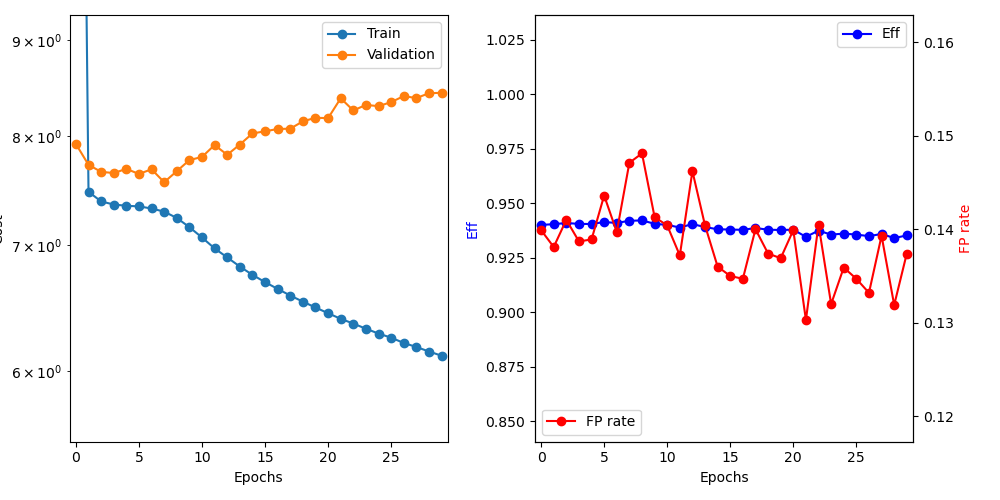

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
avgEff=0
avgFP=0
print('for model: ', model)   
run_name = 'Model Y (P5)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '3')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '2.5')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

for model:  ThreeFeature_8Layer_XYPretrain_Y(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(40, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(50, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(60, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(70, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(71, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFC): Linear(in_features=4000, out_features=4000, bias=True)
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inpla

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 1420: train=30.7319, val=7.92276, took 96.049 s
  Validation Found 51237 of 54504, added 1397 (eff 94.01%) (0.14 FP/event)
Result epoch:  1420
Average Eff:  0
Average FP Rate:  0


Epoch 1421: train=7.47209, val=7.7228, took 92.741 s
  Validation Found 51255 of 54504, added 1379 (eff 94.04%) (0.138 FP/event)
Result epoch:  1421
Average Eff:  0
Average FP Rate:  0


Epoch 1422: train=7.38393, val=7.65669, took 92.655 s
  Validation Found 51285 of 54504, added 1408 (eff 94.09%) (0.141 FP/event)
Result epoch:  1422
Average Eff:  0
Average FP Rate:  0


Epoch 1423: train=7.35606, val=7.64531, took 92.882 s
  Validation Found 51262 of 54504, added 1385 (eff 94.05%) (0.139 FP/event)
Result epoch:  1423
Average Eff:  0
Average FP Rate:  0


Epoch 1424: train=7.34497, val=7.68444, took 92.679 s
  Validation Found 51260 of 54504, added 1387 (eff 94.05%) (0.139 FP/event)
Result epoch:  1424
Average Eff:  0
Average FP Rate:  0


Epoch 1425: train=7.3391, val=7.63686, took 92.65 s
  Validation Found 51308 of 54504, added 1434 (eff 94.14%) (0.144 FP/event)
Result epoch:  1425
Average Eff:  0
Average FP Rate:  0


Epoch 1426: train=7.32036, val=7.68078, took 92.577 s
  Validation Found 51286 of 54504, added 1395 (eff 94.10%) (0.14 FP/event)
Result epoch:  1426
Average Eff:  0
Average FP Rate:  0


Epoch 1427: train=7.29214, val=7.55995, took 92.638 s
  Validation Found 51340 of 54504, added 1469 (eff 94.19%) (0.147 FP/event)
Result epoch:  1427
Average Eff:  0
Average FP Rate:  0


Epoch 1428: train=7.23604, val=7.66269, took 92.611 s
  Validation Found 51349 of 54504, added 1479 (eff 94.21%) (0.148 FP/event)
Result epoch:  1428
Average Eff:  0
Average FP Rate:  0


Epoch 1429: train=7.15495, val=7.7677, took 92.756 s
  Validation Found 51265 of 54504, added 1411 (eff 94.06%) (0.141 FP/event)
Result epoch:  1429
Average Eff:  0
Average FP Rate:  0


Epoch 1430: train=7.06479, val=7.79784, took 92.681 s
  Validation Found 51237 of 54504, added 1402 (eff 94.01%) (0.14 FP/event)
Result epoch:  1430
Average Eff:  0
Average FP Rate:  0


Epoch 1431: train=6.9709, val=7.91247, took 92.632 s
  Validation Found 51172 of 54504, added 1370 (eff 93.89%) (0.137 FP/event)
Result epoch:  1431
Average Eff:  0
Average FP Rate:  0


Epoch 1432: train=6.89437, val=7.81818, took 92.627 s
  Validation Found 51257 of 54504, added 1460 (eff 94.04%) (0.146 FP/event)
Result epoch:  1432
Average Eff:  0
Average FP Rate:  0


Epoch 1433: train=6.81773, val=7.91721, took 92.617 s
  Validation Found 51183 of 54504, added 1402 (eff 93.91%) (0.14 FP/event)
Result epoch:  1433
Average Eff:  0
Average FP Rate:  0


Epoch 1434: train=6.74875, val=8.02535, took 92.596 s
  Validation Found 51128 of 54504, added 1358 (eff 93.81%) (0.136 FP/event)
Result epoch:  1434
Average Eff:  0
Average FP Rate:  0


Epoch 1435: train=6.68864, val=8.04674, took 92.598 s
  Validation Found 51121 of 54504, added 1348 (eff 93.79%) (0.135 FP/event)
Result epoch:  1435
Average Eff:  0
Average FP Rate:  0


Epoch 1436: train=6.63348, val=8.0693, took 92.595 s
  Validation Found 51114 of 54504, added 1345 (eff 93.78%) (0.135 FP/event)
Result epoch:  1436
Average Eff:  0
Average FP Rate:  0


Epoch 1437: train=6.57969, val=8.07253, took 92.604 s
  Validation Found 51159 of 54504, added 1398 (eff 93.86%) (0.14 FP/event)
Result epoch:  1437
Average Eff:  0
Average FP Rate:  0


Epoch 1438: train=6.53065, val=8.14523, took 93.01 s
  Validation Found 51117 of 54504, added 1372 (eff 93.79%) (0.137 FP/event)
Result epoch:  1438
Average Eff:  0
Average FP Rate:  0


Epoch 1439: train=6.48404, val=8.18098, took 92.718 s
  Validation Found 51110 of 54504, added 1367 (eff 93.77%) (0.137 FP/event)
Result epoch:  1439
Average Eff:  0
Average FP Rate:  0


Epoch 1440: train=6.43872, val=8.17757, took 92.833 s
  Validation Found 51117 of 54504, added 1397 (eff 93.79%) (0.14 FP/event)
Result epoch:  1440
Average Eff:  0
Average FP Rate:  0


Epoch 1441: train=6.39459, val=8.37881, took 92.701 s
  Validation Found 50939 of 54504, added 1301 (eff 93.46%) (0.13 FP/event)
Result epoch:  1441
Average Eff:  0
Average FP Rate:  0


Epoch 1442: train=6.35765, val=8.2545, took 92.61 s
  Validation Found 51093 of 54504, added 1403 (eff 93.74%) (0.141 FP/event)
Result epoch:  1442
Average Eff:  0
Average FP Rate:  0


Epoch 1443: train=6.31751, val=8.31104, took 92.656 s
  Validation Found 50994 of 54504, added 1318 (eff 93.56%) (0.132 FP/event)
Result epoch:  1443
Average Eff:  0
Average FP Rate:  0


Epoch 1444: train=6.28021, val=8.29828, took 92.613 s
  Validation Found 51020 of 54504, added 1357 (eff 93.61%) (0.136 FP/event)
Result epoch:  1444
Average Eff:  0
Average FP Rate:  0


Epoch 1445: train=6.24853, val=8.33974, took 92.79 s
  Validation Found 50995 of 54504, added 1345 (eff 93.56%) (0.135 FP/event)
Result epoch:  1445
Average Eff:  0
Average FP Rate:  0


Epoch 1446: train=6.20827, val=8.40103, took 92.624 s
  Validation Found 50956 of 54504, added 1330 (eff 93.49%) (0.133 FP/event)
Result epoch:  1446
Average Eff:  0
Average FP Rate:  0


Epoch 1447: train=6.17782, val=8.38105, took 92.62 s
  Validation Found 51011 of 54504, added 1391 (eff 93.59%) (0.139 FP/event)
Result epoch:  1447
Average Eff:  0
Average FP Rate:  0


Epoch 1448: train=6.14367, val=8.43074, took 92.655 s
  Validation Found 50908 of 54504, added 1317 (eff 93.40%) (0.132 FP/event)
Result epoch:  1448
Average Eff:  0
Average FP Rate:  0


Epoch 1449: train=6.11185, val=8.43546, took 92.657 s
  Validation Found 50974 of 54504, added 1372 (eff 93.52%) (0.137 FP/event)
Result epoch:  1449
Average Eff:  0
Average FP Rate:  0


In [ ]:
##quit()